In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [2]:
loaded_classifier = pickle.load(open('classifier_model.sav', 'rb'))
loaded_regressor = pickle.load(open('regressor_model.sav', 'rb'))

In [98]:
df_simulation_5 = pd.read_csv('version_2/Predict500_5yr.csv')
df_simulation_10 = pd.read_csv('version_2/Predict500_10yr.csv')

In [99]:
default_count = df_simulation_5.groupby('simulation')['simulation'].count()
default_count.mean()

10.225828729281767

In [100]:
default_count = df_simulation_10.groupby('simulation')['simulation'].count()
default_count.mean()

18.684827586206897

### Format

In [101]:
df_simulation_5 = df_simulation_5.fillna(df_simulation_5.mean())
df_simulation_10 = df_simulation_10.fillna(df_simulation_10.mean())

In [102]:
df_simulation_5 = df_simulation_5.drop(columns=['Unnamed: 0','loan'])
df_simulation_10 = df_simulation_10.drop(columns=['Unnamed: 0','loan'])
df_simulation_5 = df_simulation_5.rename(columns={"age": "loan_age","SP500": "S&P500"})
df_simulation_10 = df_simulation_10.rename(columns={"age": "loan_age","SP500": "S&P500"})

In [103]:
df = pd.read_csv('loss_dataset.csv')
df['ChargeOffDate'] = pd.to_datetime(df['ChargeOffDate'])
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'])
df['loan_age'] = (df['ChargeOffDate'] - df['ApprovalDate'])/np.timedelta64(1, 'M')
df['loss_pcrt'] = df['GrossChargeOffAmount'] / df['GrossApproval']
df = df.drop(columns=['Unnamed: 0','LoanStatus','log_amount','end_date','quarter_index','ApprovalDate','ChargeOffDate',
                      'ChargeOffDate','time','status','id','death','time_start','time_end','ApprovalYear','EndYear',
                     'BorrState','indicator_Leverage','indicator_HPI','indicator_IndustryGDP',
                     'indicator_UnemploymentRate', 'indicator_PersonalIncome',
                     'indicator_GSP','indicator_NaicsCode','Unnamed: 0.1','GrossChargeOffAmount','loss_pcrt'])
cols = list(df.columns)
df['simulation'] = 1000000000
cols = ['simulation']  + cols
df = df[cols]

In [104]:
df_simulation_5 = df_simulation_5[cols]
df_simulation_10 = df_simulation_10[cols]
df_simulation_5 = pd.concat([df_simulation_5,df])
df_simulation_10 = pd.concat([df_simulation_10,df])
df_simulation_5 = pd.get_dummies(df_simulation_5)
df_simulation_10 = pd.get_dummies(df_simulation_10)
df_simulation_5 = df_simulation_5[df_simulation_5['simulation']!=1000000000]
df_simulation_10 = df_simulation_10[df_simulation_10['simulation']!=1000000000]
df_simulation_5 = df_simulation_5.reset_index()
df_simulation_10 = df_simulation_10.reset_index()
df_simulation_5 = df_simulation_5.drop(columns=['index'])
df_simulation_10 = df_simulation_10.drop(columns=['index'])

### Loss 

In [105]:
def calculate_loss(df,clf,regr):
    loss = []
    simulation_id_list = df['simulation'].unique()
    for simulation_id in simulation_id_list:
        sub = df[df['simulation']==simulation_id]
        sub = sub.reset_index()
        X = sub.iloc[:,3:]
        Y = sub['GrossApproval']
        prediction_recovery = clf.predict_proba(X)[:,1]
        prediction_loss = regr.predict(X)
        y_pred_recovery = [1 if x < 0.55 else 0 for x in prediction_recovery]
        y_pred_loss = np.array(y_pred_recovery) * np.array(prediction_loss) * np.array(Y)
        loss.append(sum(y_pred_loss))
    return loss

In [106]:
loss_5 = calculate_loss(df_simulation_5,loaded_classifier,loaded_regressor)

In [107]:
loss_10 = calculate_loss(df_simulation_10,loaded_classifier,loaded_regressor)

In [108]:
label = ['5 year' for i in range(len(loss_5))]
label2 = ['10 year' for i in range(len(loss_10))]
label.extend(label2)

In [109]:
loss = loss_5[:]
loss.extend(loss_10)

In [110]:
df_loss = pd.DataFrame()
df_loss['period'] = label
df_loss['loss'] = loss

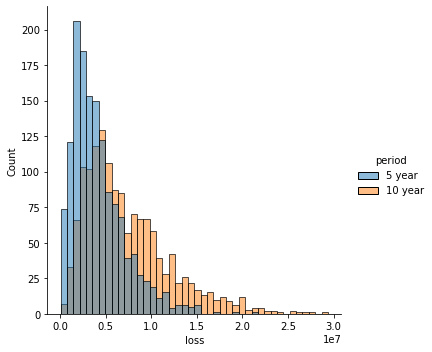

In [128]:
sns.displot(df_loss, x="loss", hue="period")
##plt.title('Loss Distribution over 5 and 10 Year')

In [129]:
loss_list = loss[:]
loss_list = np.sort(loss_list)

In [130]:
def get_VaR(loss,quantile):
    loss_list = []
    avg_loss_list = []
    n = len(loss)
    for i in range(1000):
        loss_copy = loss[:]
        loss_copy = np.random.choice(loss_copy,size=n,replace=True)
        loss_copy = np.sort(loss_copy)
        loss_quantile = loss_copy[int(n*quantile)]
        avg_loss = loss_copy[int(n*quantile):]
        loss_list.append(loss_quantile)
        avg_loss_list.append(np.mean(avg_loss))
    var_mean = np.mean(loss_list)
    var_upper = var_mean + 1.96 * np.std(loss_list)
    var_lower = var_mean - 1.96 * np.std(loss_list)
    avar_mean = np.mean(avg_loss_list)
    avar_upper = avar_mean + 1.96 * np.std(avg_loss_list)
    avar_lower = avar_mean - 1.96 * np.std(avg_loss_list)
    return var_mean,var_upper,var_lower,avar_mean,avar_upper,avar_lower

In [131]:
loss_5_var_95, loss_5_var_95_upper,loss_5_var_95_lower,loss_5_avar_95, loss_5_avar_95_upper,loss_5_avar_95_lower = get_VaR(loss_5,0.95)
loss_5_var_99, loss_5_var_99_upper,loss_5_var_99_lower,loss_5_avar_99, loss_5_avar_99_upper,loss_5_avar_99_lower = get_VaR(loss_5,0.99)
loss_10_var_95, loss_10_var_95_upper,loss_10_var_95_lower,loss_10_avar_95, loss_10_avar_95_upper,loss_10_avar_95_lower = get_VaR(loss_10,0.95)
loss_10_var_99, loss_10_var_99_upper,loss_10_var_99_lower,loss_10_avar_99, loss_10_avar_99_upper,loss_10_avar_99_lower = get_VaR(loss_10,0.99)

In [132]:
print(loss_5_var_95, loss_5_var_95_upper,loss_5_var_95_lower)
print(loss_5_var_99, loss_5_var_99_upper,loss_5_var_99_lower)
print(loss_10_var_95, loss_10_var_95_upper,loss_10_var_95_lower)
print(loss_10_var_99, loss_10_var_99_upper,loss_10_var_99_lower)

9907483.17293158 10437404.887577374 9377561.458285786
13779522.026881274 14691635.746537149 12867408.307225399
16753887.572478835 17582107.685639985 15925667.459317684
21802143.24375989 23232972.16767735 20371314.319842428


In [133]:
print(loss_5_avar_95, loss_5_avar_95_upper,loss_5_avar_95_lower)
print(loss_5_avar_99, loss_5_avar_99_upper,loss_5_avar_99_lower)
print(loss_10_avar_95, loss_10_avar_95_upper,loss_10_avar_95_lower)
print(loss_10_avar_99, loss_10_avar_99_upper,loss_10_avar_99_lower)

12212593.104516855 12934044.511402661 11491141.697631048
15393032.914703583 16677618.063048176 14108447.76635899
19868831.766551923 20797252.529849134 18940411.00325471
24321598.71217244 26062775.417601697 22580422.006743185


In [134]:
def get_tranche(loss,lower,upper):
    loss_list = []
    for l in loss:
        if l>=lower:
            loss_list.append(min(upper,l)-lower)
        else:
            loss_list.append(0)
    return loss_list

In [141]:
df_portfolio = pd.read_csv('time_varing_portfolio_500_loans.csv')
df_portfolio = df_portfolio.drop_duplicates(subset=['id'], keep='last')
TotalApproval = df_portfolio['GrossApproval'].sum()

In [142]:
tranche_5 = TotalApproval * 0.05
tranche_15 = TotalApproval * 0.15
junior_loss_5 = get_tranche(loss_5,tranche_5,tranche_15)
senior_loss_5 = get_tranche(loss_5,tranche_5,TotalApproval)
junior_loss_10 = get_tranche(loss_10,tranche_5,tranche_15)
senior_loss_10 = get_tranche(loss_10,tranche_15,TotalApproval)

In [143]:
label = ['5 year' for i in range(len(junior_loss_5))]
label2 = ['10 year' for i in range(len(junior_loss_10))]
label.extend(label2)

loss = junior_loss_5[:]
loss.extend(junior_loss_10)

df_loss_junior = pd.DataFrame()
df_loss_junior['period'] = label
df_loss_junior['loss'] = loss

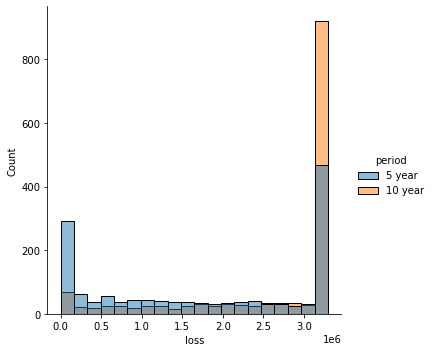

In [147]:
sns.displot(df_loss_junior, x="loss", hue="period",bins=20)
##plt.title('[5%, 15%] Tranche Loss Distribution over 5 and 10 Year')

In [145]:
label = ['5 year' for i in range(len(senior_loss_5))]
label2 = ['10 year' for i in range(len(senior_loss_10))]
label.extend(label2)

loss = senior_loss_5[:]
loss.extend(senior_loss_10)

df_loss_senior = pd.DataFrame()
df_loss_senior['period'] = label
df_loss_senior['loss'] = loss

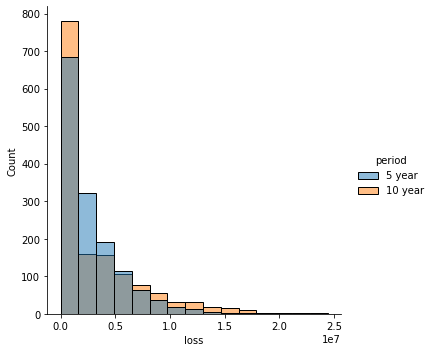

In [148]:
sns.displot(df_loss_senior, x="loss", hue="period",bins=15)
##plt.title('[15%, 100%] Loss Distribution over 5 and 10 Year')

In [124]:
label = ['[5%,15%] tranche' for i in range(len(junior_loss_5))]
label2 = ['[15%,100%] tranche' for i in range(len(senior_loss_5))]
label.extend(label2)

loss = junior_loss_5[:]
loss.extend(senior_loss_5)

df_loss_5 = pd.DataFrame()
df_loss_5['tranche'] = label
df_loss_5['loss'] = loss

Text(0.5, 1.0, '5-year Loss Distribution by Tranche')

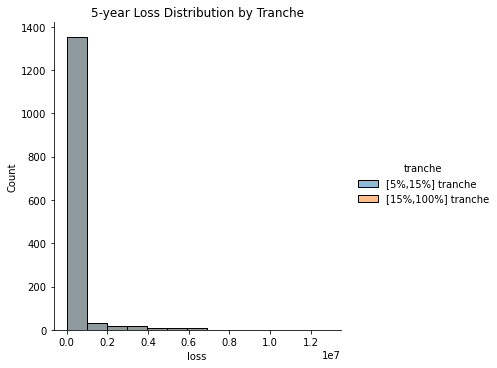

In [125]:
sns.displot(df_loss_5, x="loss", hue="tranche")
plt.title('5-year Loss Distribution by Tranche')

In [126]:
label = ['[5%,15%] tranche' for i in range(len(junior_loss_10))]
label2 = ['[15%,100%] tranche' for i in range(len(senior_loss_10))]
label.extend(label2)

loss = junior_loss_10[:]
loss.extend(senior_loss_10)

df_loss_10 = pd.DataFrame()
df_loss_10['tranche'] = label
df_loss_10['loss'] = loss

Text(0.5, 1.0, '10-year Loss Distribution by Tranche')

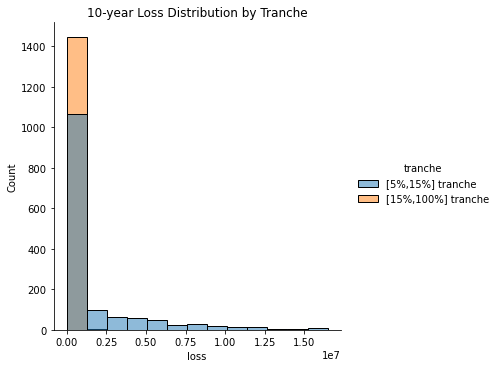

In [127]:
sns.displot(df_loss_10, x="loss", hue="tranche")
plt.title('10-year Loss Distribution by Tranche')